# <center> Naive Bayes and Logistic Classifiers </center>
### <div align=right> Made by:</div>
**<div align=right>Saheli Ganguly</div>** 
**<div align=right>Ihor Markevych</div>**

In [1]:
import numpy as np
import sklearn.linear_model as LM
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Markdown

## Problem 1

### (a)  
  
$$f(x)=x^2+6x$$
$$\frac{df(x)}{dx}=2x+6$$
$$\frac{df(x)}{dx}=0=>2x+6=0=>x^*=-3$$

### (b)

One can perform gradient descent either by providing the gradient explicitly or by computing the gradient numerically. We try both these methods and show the solution below.

In [2]:
def gradient(f, x, *args, **kwargs):
    res = []
    if np.array(x).shape == ():
        h = x * 1e-10 ** (1 / 3) if x != 0 else 1e-10
        return (f(x + h, *args, **kwargs) - f(x - h, *args, **kwargs)) / 2 / h
    
    x = list(x)     
    for i, xi in enumerate(x):
        h = xi * 1e-10 ** (1 / 3) if xi != 0 else 1e-10
        res.append((f(np.array(x[:i] + [x[i] + h] + x[(i + 1):]), *args, **kwargs) 
                   - f(np.array(x[:i]+ [x[i] - h] + x[(i + 1):]), *args, **kwargs)) / 2 / h)
    return np.array(res)

def gradientDescent(f=None, df=None, initX=None, 
                    lr=0.1, maxIters=1e5, eps=1e-6, *args, **kwargs):
    if initX is None:
        x = np.random.uniform(-100, 100)
    else:
        x = initX
    i = 0
    
    if df is not None:
        grad = lambda x: df(x, *args, **kwargs)
    elif f is not None:
        grad = lambda x: gradient(f, x, *args, **kwargs)
    else:
        raise Exception('Provide either function or gradient!')
    
    while i < maxIters and np.linalg.norm(grad(x)) > eps:
        i += 1
        x = x - lr * grad(x)
    return x

In [3]:
def f(x):
    return x ** 2 + 6 * x

def df(x):
    return 2*x + 6

print(f'Result for a gradient descent with numerical computation of gradient: {gradientDescent(f=f)}.')
print(f'Result for a gradient descent with analytical computation of gradient: {gradientDescent(df=df)}.')

Result for a gradient descent with numerical computation of gradient: -3.0000004703769636.
Result for a gradient descent with analytical computation of gradient: -3.00000047111901.


As it can be seen, both methods give results that are same up to precision $\epsilon$.

## Problem 2

In [4]:
data = pd.read_csv('Oring.csv')

Original data:

In [5]:
data

,Temp,Failure
0,53,1
1,56,1
2,57,1
3,63,0
4,66,0
5,67,0
6,67,0
7,67,0
8,68,0
9,69,0


Note: in the following implementation the next formulas were used:  
$\mu = \frac{\sum_{i=1}^N x}{N}$  
$\sigma = \sqrt{\frac{\sum_{i=1}^N (x-\mu)^2} {N-1}}$  
Commonly, for $\sigma$ estimator $\sqrt{\frac{\sum_{i=1}^N (x-\mu)^2} {N}}$ is used. However, to make statistical estimation not only unbiased, but also efficient, we have used $N-1$. Usually there is no significant difference between those estimates because of big sample size, but in our case sample size is small and estimations vary.

In [6]:
class Normalizer:
    def fit(self, data):
        self.mu = np.average(data)
        self.sigma = (sum((data - self.mu) ** 2) / (len(data) - 1)) ** 0.5
        
    def scale(self, data):
        return (data - self.mu) / self.sigma
    
    def fitAndScale(self, data):
        self.fit(data)
        return self.scale(data)

In [7]:
norm = Normalizer()
trainX = norm.fitAndScale(data['Temp'])
trainY = data['Failure']

Transformed data:

In [8]:
trainX

0    -2.293007
1    -1.886366
2    -1.750818
3    -0.937535
4    -0.530893
5    -0.395346
6    -0.395346
7    -0.395346
8    -0.259799
9    -0.124252
10    0.011296
11    0.011296
12    0.011296
13    0.011296
14    0.282390
15    0.417937
16    0.689032
17    0.689032
18    0.824579
19    0.824579
20    1.095673
21    1.231221
22    1.366768
23    1.502315
Name: Temp, dtype: float64

Given a collection of training data $(\mathbf{x}_n, y_n)_{n=1}^{N}$, the objective function of the logistic regression model can be written as follows:
$$J(\mathbf{\tilde{w}}) = -\frac{1}{N}\sum_{n=1}^{N} (y_n \text{log}(h_{\mathbf{\tilde{w}}}(\mathbf{x}_n)) + (1 - y_n) \text{log}(1 - h_{\mathbf{\tilde{w}}}(\mathbf{x}_n))).$$ Here $\mathbf{x}_n \in \mathbb{R}^{D}$ is the $D$-dimensional feature pressentation for the $n^{\text{th}}$ data point. $\mathbf{w} \in \mathbb{R}^{D}$ is the set of coefficients corresponding to the $D$ features and $w_0$ is the bias term; together they compose $\mathbf{\tilde{w}} = (w_0, \mathbf{w})$ -- the parameters of a logistic regression model that one needs to learn from the training data. Also, $h_{\mathbf{\tilde{w}}}(\mathbf{x}_n) = \sigma(w_0 + \langle \mathbf{w}, \mathbf{x}_n\rangle)$ and $\sigma(x) = \frac{1}{1 + e^{-x}}$ is the logistic sigmoid function.

Note that this realization of the objective function follows directly from the maximum likelihood formulation. Given a training data $(\mathbf{x}_n, y_n)_{n=1}^{N}$, one is interested in modeling the joint likelihood of the targets $\{y_n\}_{n=1}^{N}$ as:
$$p(\{y_n\}_{n=1}^{N}| \mathbf{\tilde{w}}) = \prod_{n=1}^{N} h_{\mathbf{\tilde{w}}}(\mathbf{x}_n)*{y_n} (1 - h_{\mathbf{\tilde{w}}}(\mathbf{x}_n)*{(1- y_n)}.$$ The product over all the training data points is derived from the i.i.d assumption. Since our objective is to maximize this likelihood, we can use a monotonic transformation on this likelihood, such as logarithm, without changing the maximizer. Taking logarithm of the above likelihood gives rise to the log-likehood function. Maximizing this log-likehood is equivalent to minimizing the negative of the log-likelihood, which we state in the beginning of this section (we also divide the objective function by $N$ without changing the minimizer, this aspect will be important when we introduce the regularization term next). One can also show that the objective function is convex by calculating the Hessian at any point and showing that the Hessian matrix truns out to be positive-semidefinite. 

Often regularization term is introduced to prevent overfitting. With such regularization, the objective gets slightly modified to $J(\mathbf{w}) = -\frac{1}{N} \sum_{n=1}^{N} (y_n \text{log}(h_{\mathbf{w}}(\mathbf{x}_n)) + (1 - y_n) \text{log}(1 - h_{\mathbf{w}}(\mathbf{x}_n))) + \frac{\lambda}{2N} ||\mathbf{w}[1:]||_{2}^{2}$, where $\lambda$ is the regularization parameter. Note: $w_0$, bias term, is not included in regularization term.  
  
With such modified objective, the gradient is derived as below: 
$$\frac{\partial J}{\partial \tilde{w}_j} = \frac{1}{N}((\lambda {w}_j + \sum_{n=1}^{N} (h_{\tilde{w}_j}(\mathbf{x}_n) - y_n) \mathbf{x}_n), j=1,N$$   
$$\frac{\partial J}{\partial \tilde{w}_0} = \frac{1}{N}(\sum_{n=1}^{N} (h_{\tilde{w}_0}(\mathbf{x}_n) - y_n) \mathbf{x}_n$$
  
Since the objective function is convex, the value of it decreases with every iteration of gradient descent when the learning rate is set appropriately. When learning rate is too high, gradient of the objective function starts to osciallatate and no convergence is achieved.

In [9]:
class LogisticRegression:
        
    @staticmethod
    def sigmoid(weights, X):
        """
        sigmoid (logistic) function (vectorized)
        """
        if isinstance(X, int) or isinstance(X, float):
            X = np.array([X])
        else:
            X = np.array(X)
        X = np.insert(X[:, None], 0, 1, axis=1)
        return 1 / (1 + np.exp(- X @ weights))
    
    @staticmethod
    def objectiveFunction(weights, X, y, regularizationCoefficient=1):
        """
        cost function of logistic regression
        """
        return sum(- y * np.log(LogisticRegression.sigmoid(weights, X)) 
                   - (1 - y) * np.log(1 - LogisticRegression.sigmoid(weights, X))) / len(X) \
                + np.linalg.norm(weights[1:]) ** 2 * regularizationCoefficient / 2 / len(X)    
    
    def __init__(self, regularizationCoefficient=0, 
                 learningRate = 0.1, maxIters=1000, precision=1e-10):
        
        self.lr = learningRate
        self.maxIters = maxIters
        self.precision = precision
        self.regularizationCoefficient = regularizationCoefficient
    
    def fit(self, X):
        """
        initialize weights to zero
        """
        self.w = np.zeros(np.array(X).reshape(-1,1).shape[1] + 1)
    
    def train(self, X, y):
        """
        training process of logistic regression
        """
        self.fit(X)
            
        self.w = gradientDescent(f=LogisticRegression.objectiveFunction,
                                 lr=self.lr, initX=self.w, 
                                 maxIters=self.maxIters, eps=self.precision,
                                 X=X, y=y, regularizationCoefficient=self.regularizationCoefficient)
        
    def predictProb(self, X):
        """
        predict probability
        """
        return self.sigmoid(self.w, X)
    
    def predict(self, X):
        """
        predict label
        """
        return int(self.predictProb(X) > 0.5)
    
    def showFormula(self):
        """
        show explicit formula of created model
        """
        display(Markdown('$p(y=1|x)=\\frac{1}{1+e^{(' + str(self.w) + ', x)}}$'))

### Unregularized Logistic Regression

In [10]:
logR = LogisticRegression(regularizationCoefficient=0)
logR.train(trainX, trainY)
logR.showFormula()

$p(y=1|x)=\frac{1}{1+e^{([-1.10277317 -1.26386114], x)}}$

Quick check:

In [11]:
LR = LM.LogisticRegression(C=np.Inf)
LR.fit(np.array(trainX).reshape(-1, 1), trainY)
np.hstack((LR.intercept_[:,None], LR.coef_))

array([[-1.10281036, -1.26391916]])

In [12]:
print(f"Model predicted {'failure' if logR.predict(norm.scale(31)) == 1 else 'no failure'} with probability {logR.predictProb(norm.scale(31))[0]}.")

Model predicted failure with probability 0.9961818095018504.


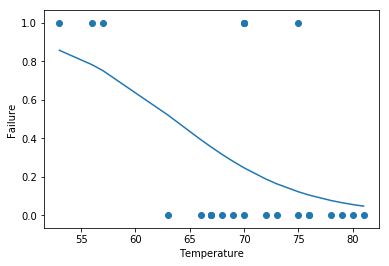

In [13]:
plt.scatter(data['Temp'], data['Failure'])
plt.xlabel('Temperature')
plt.ylabel('Failure')
plt.plot(data['Temp'], logR.predictProb(trainX))
plt.show()

### Regularized Logistic Regression with $\lambda=1$

In [14]:
logR = LogisticRegression(regularizationCoefficient=1)
logR.train(trainX, trainY)
logR.showFormula()

$p(y=1|x)=\frac{1}{1+e^{([-1.02632426 -0.95263152], x)}}$

Quick check:

In [15]:
LR = LM.LogisticRegression()
LR.fit(np.array(trainX).reshape(-1, 1), trainY)
np.hstack((LR.intercept_[:,None], LR.coef_))

array([[-1.02632602, -0.95263306]])

In [16]:
print(f"Model predicted {'failure' if logR.predict(norm.scale(31)) == 1 else 'no failure'} with probability {logR.predictProb(norm.scale(31))[0]}.")

Model predicted failure with probability 0.9819934910104956.


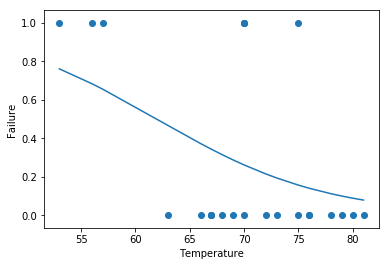

In [17]:
plt.scatter(data['Temp'], data['Failure'])
plt.xlabel('Temperature')
plt.ylabel('Failure')
plt.plot(data['Temp'], logR.predictProb(trainX))
plt.show()

### Results discussion

We can see that both the models predict that the probability of failure at launch would have been close to $1$. However, drawing any conclusion of either of these models could be risky because of the small sample size. Since we do not have access to a good test set (we evaluate the model only on single test point -- the challenger failure instance), we cannot evaluate the generalization error of these models. Finally, the generalization error is also contingent on the cost of false-positive and false-negative, which we do not have much idea about here. For example, we know that the cost of a false-negative prediction is catastrophic, but we are not sure what false-positive cost we might have to bear that is associated with launch date delays, government regulations, weather conditions etc.

# Appendix

### Comparing different learning rates

In [18]:
def gradientDescentWithHist(f, initX = None, 
                    lr=0.1, maxIters=1e5, eps=1e-6, *args, **kwargs):
    histX = []
    if initX is None:
        x = np.random.uniform(-100, 100)
    else:
        x = initX
    i = 0
    while i < maxIters and np.linalg.norm(gradient(f, x, *args, **kwargs)) > eps:
        i += 1
        histX.append(x)
        x = x - lr * gradient(f, x, *args, **kwargs)
    return x, histX

In the following cell we will demonstrate effects of different learning rates:
- if learning rate is set too high, method will not converge;
- if learning rate is set appropriatly, method will converge quickly;
- if learning rate is set too small, method will converge, but slow.

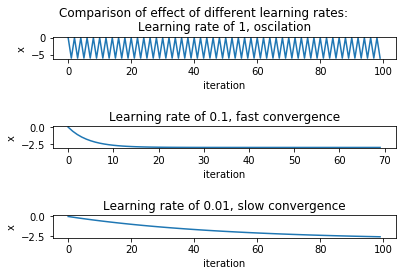

In [19]:
fig = plt.figure()

plt.suptitle('Comparison of effect of different learning rates:')

plt.subplot(3, 1, 1)
plt.title('Learning rate of 1, oscilation')
plt.xlabel('iteration')
plt.ylabel('x')
histX = gradientDescentWithHist(f, initX = 0, lr=1, maxIters=100)[1]
plt.plot([x for x in range(len(histX))], histX)

plt.subplot(3, 1, 2)
plt.title('Learning rate of 0.1, fast convergence')
plt.xlabel('iteration')
plt.ylabel('x')
histX = gradientDescentWithHist(f, initX = 0, lr=0.1, maxIters=100)[1]
plt.plot([x for x in range(len(histX))], histX)

plt.subplot(3, 1, 3)
plt.title('Learning rate of 0.01, slow convergence')
plt.xlabel('iteration')
plt.ylabel('x')
histX = gradientDescentWithHist(f, initX = 0, lr=0.01, maxIters=100)[1]
plt.plot([x for x in range(len(histX))], histX)

fig.tight_layout(pad=2.0)
plt.show()